# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [4]:
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import os
import pickle
import copy
from PIL import Image

In [5]:
# TODO: Fill this in based on where you saved the training and testing data
filePath = 'traffic-signs-data/'
training_file = filePath+'train.p'
validation_file= filePath+'valid.p'
testing_file = filePath+'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [6]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
labels = pd.read_csv('signnames.csv')
n_classes = len(labels)

print("Number of training examples: x={0}, y={1}".format(n_train, y_train.shape[0]))
print("Number of validation examples: x={0}, y={1}".format(n_validation, y_valid.shape[0]))
print("Number of testing examples:  x={0}, y={1}".format(n_test, y_test.shape[0]))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples: x=34799, y=34799
Number of validation examples: x=4410, y=4410
Number of testing examples:  x=12630, y=12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [7]:
y_train_df = pd.DataFrame(data=y_train, columns=['ClassId'])
y_valid_df = pd.DataFrame(data=y_valid, columns=['ClassId'])
y_test_df = pd.DataFrame(data=y_test, columns=['ClassId'])

grouped_train_index = y_train_df.groupby('ClassId')
grouped_valid_index = y_valid_df.groupby('ClassId')
grouped_test_index = y_test_df.groupby('ClassId')

## Get the first index images in each class
firstTrainDataForEachClass = grouped_train_index.head(1).sort_values('ClassId').reset_index()
#print(firstTrainDataForEachClass)

In [ ]:
## Plot class ID from index 0 to 9
numOfRows = 5
numOfColumns = 2

ClassIdIndex = 0

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(20, 20))
sns.set_style(style='white')

for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=20)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 10:
            break

plt.tight_layout()

In [ ]:
## Plot classes from index 10 to 19
numOfRows = 5
numOfColumns = 2
ClassIdIndex = 10

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(20, 20))
sns.set_style(style='white')

for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=20)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 20:
            break

plt.tight_layout()

In [ ]:
## Plot classes from index 20 to 29
numOfRows = 5
numOfColumns = 2
ClassIdIndex = 20

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(20, 20))
sns.set_style(style='white')

for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=20)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 30:
            break

plt.tight_layout()

In [ ]:
## Plot classes from index 30 to 39
numOfRows = 5
numOfColumns = 2
ClassIdIndex = 30

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(20, 20))
sns.set_style(style='white')

for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=20)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 40:
            break

plt.tight_layout()

In [ ]:
## Plot classes from index 40 to 42
numOfRows = 2
numOfColumns = 2

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(10, 10))
sns.set_style(style='white')
ClassIdIndex = 40
for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=20)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 43:
            break

plt.tight_layout()

In [ ]:
numOfSamples = pd.DataFrame()
numOfSamples['Label'] = labels['SignName']

numOfSamples['Number of Samples'] = grouped_train_index.size()
#print(numOfSamples['Number of Samples'])
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(x='Number of Samples', y='Label', data=numOfSamples)
ax.set(xlim=(0, 2100), ylabel="Classes", xlabel="Number of Samples")
ax.set_title('Number of samples in each class', size=20)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [45]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

## Ganussian Filter
def gaussianFilter(img):
    # Gaussian filter
    filter_size = 3
    filter_sigma = 0.2
    gaussian_filter = np.dot(cv2.getGaussianKernel(filter_size, 
                                                   filter_sigma, 
                                                   cv2.CV_64F),
                            (cv2.getGaussianKernel(filter_size, 
                                                   filter_sigma, 
                                                   cv2.CV_64F)).T)

    img_filtered = cv2.filter2D(img, -1, 
                                gaussian_filter, 
                                borderType=cv2.BORDER_REFLECT_101) # reflect across edge filter
    
    return img_filtered

## Normalisation
def normaliseColourImages(images):
    images = images.astype(np.float32)
    for idx, img in tqdm(enumerate(images)):
        images[idx] = cv2.normalize(img, dst=img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return images

## Enhance Contrast using histogram equalization
def enhanceContrastOfImage(img):
    #yuv_img = cv2.cvtColor(norm_img, cv2.COLOR_RGB2YUV)
    #yuv_img[:,:,0] = cv2.equalizeHist(yuv_img[:,:,0])
    # return cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)
    if np.mean(img) < 50:
        brightImage = img.copy()
        brightImage[:,:,0] = cv2.equalizeHist(img[:,:,0])
        brightImage[:,:,1] = cv2.equalizeHist(img[:,:,1])
        brightImage[:,:,2] = cv2.equalizeHist(img[:,:,2])
        return brightImage
    return img

def sharpenImage(img):
    kernelOfSharpener = np.array([[-1,-1,-1,-1,-1], 
                                 [-1,2,2,2,-1], 
                                 [-1,2,8,2,-1],
                                 [-1,2,2,2,-1],
                                 [-1,-1,-1,-1,-1]]) / 8.0
    return cv2.filter2D(img, -1, kernelOfSharpener)

def affineTransformation(img):
    row, column = X_train[8000].shape[:2]
    sourcePoints = np.float32([[0, 0], [column-1, 0], [0, row-1]])

    destinationPoints = np.float32([[np.random.uniform(low=0., high=0.2, size=1)[0]*(row-1), np.random.uniform(low=0., high=0.2, size=1)[0]*(column-1)], 
                                    [np.random.uniform(low=0.7, high=1, size=1)[0]*(row-1), np.random.uniform(low=0., high=0.2, size=1)[0]*(column-1)], 
                                    [np.random.uniform(low=0., high=0.2, size=1)[0]*(row-1), np.random.uniform(low=0.7, high=1, size=1)[0]*(column-1)]])

    affine_matrix = cv2.getAffineTransform(sourcePoints, destinationPoints)
    #img_output = cv2.warpAffine(X_train[8000], affine_matrix, (row, column))
    
    return cv2.warpAffine(X_train[8000], affine_matrix, (row, column))

def translateImageWithRandomDistance(img):
    row, column = img.shape[:2]
    matrixForTranslation = np.array([ [1, 0, np.random.randint(low=-5, high=5)], [0, 1, np.random.randint(low=-5, high=5)] ], dtype=float)
    translatedImage = cv2.warpAffine(img, matrixForTranslation, (row, column))
    return translatedImage

def rotateImageWithRandomAngle(img):
    row, column = img.shape[:2]
    matrixForRotation = cv2.getRotationMatrix2D((column/2, row/2), np.random.randint(low=-45, high=45), 1)
    rotatedImage = cv2.warpAffine(img, matrixForRotation, (row, column))
    return rotatedImage
'''
def makeBallanceBetweenClasses(grouped_y_index=None, xData=None, yData=None):
    ## balance the number of samples in classes
    maxSampleNumbersAmongClasses = max(grouped_y_index.size())
    argmaxSampleNumbersAmongClasses = np.argmax(grouped_y_index.size())
    #print(maxSampleNumbersAmongClasses, argmaxSampleNumbersAmongClasses)

    print('The number of original samples', np.shape(xData)[0])
    augmented_X = copy.deepcopy(xData)
    augmented_y = copy.deepcopy(yData)
    for idx, value in tqdm(grouped_y_index.groups.items()):
        # get indices in a group
        local_random_indices = np.random.randint(0, len(grouped_y_index.groups[idx]), 
                                                 maxSampleNumbersAmongClasses - len(value))
        # get indices in an entire dataset
        global_random_indices = grouped_y_index.groups[idx][local_random_indices]
        #augmented_X_train = 
        augmented_X = np.append(augmented_X, augmented_X[global_random_indices], axis = 0)
        #augmented_y_train = 
        augmented_y = np.append(augmented_y, augmented_y[global_random_indices])
    print('The number of augmented samples', np.shape(augmented_X)[0])
    return augmented_X, augmented_y
'''
def makeBallanceBetweenClasses(grouped_y_index=None, xData=None, yData=None):
    ## balance the number of samples in classes
    maxSampleNumbersAmongClasses = max(grouped_y_index.size())
    argmaxSampleNumbersAmongClasses = np.argmax(grouped_y_index.size())
    #print(maxSampleNumbersAmongClasses, argmaxSampleNumbersAmongClasses)

    print('The number of original samples', np.shape(xData)[0])
    #augmented_X = copy.deepcopy(xData)
    #augmented_y = copy.deepcopy(yData)
    for idx, value in tqdm(grouped_y_index.groups.items()):
        # get indices in a group
        local_random_indices = np.random.randint(0, len(grouped_y_index.groups[idx]), 
                                                 maxSampleNumbersAmongClasses - len(value))
        # get indices in an entire dataset
        global_random_indices = grouped_y_index.groups[idx][local_random_indices]
        augmented_X = xData[global_random_indices]
        augmented_y = yData[global_random_indices]
        
        for idx, img in enumerate(augmented_X):
            augmented_X[idx] = transAndRotate(img)
            
        #xData = np.append(xData, augmented_X, axis = 0)
        xData = np.vstack([xData, augmented_X])
        #yData = np.append(yData, augmented_y)
        yData = np.hstack([yData, augmented_y])
        
    print('The number of augmented samples', np.shape(xData)[0])
    return xData, yData
'''

def makeBallanceBetweenClasses(grouped_y_index=None, xData=None, yData=None):
    ## balance the number of samples in classes
    maxSampleNumbersAmongClasses = max(grouped_y_index.size())
    argmaxSampleNumbersAmongClasses = np.argmax(grouped_y_index.size())
    #print(maxSampleNumbersAmongClasses, argmaxSampleNumbersAmongClasses)

    print('The number of original samples', np.shape(xData)[0])
    for class_idx, value_in_class in tqdm(grouped_y_index.groups.items()):
        if class_idx > 0:
            break
            
        augmented_X = np.empty([maxSampleNumbersAmongClasses - len(value_in_class), 32, 32, 3], dtype=np.float64)
        augmented_y = np.empty(maxSampleNumbersAmongClasses - len(value_in_class), dtype=np.float64)
        
        # get indices in a group
        local_random_indices = np.random.randint(0, len(grouped_y_index.groups[class_idx]), 
                                                 maxSampleNumbersAmongClasses - len(value_in_class))
        # get indices in an entire dataset
        global_random_indices = grouped_y_index.groups[class_idx][local_random_indices]
        print('>>>', augmented_X.shape, global_random_indices.shape)
        print(global_random_indices)
        for sample_idx, sample_value in enumerate(global_random_indices):
            #print(xData[global_random_indices].shape)
            #aaa[0] = Image.fromarray(X_train[0], 'RGB')
            augmented_X[sample_idx] = Image.fromarray(xData[sample_value], 'RGB')
            augmented_y[sample_idx] = yData[sample_value]

        xData = np.vstack([xData, augmented_X])
        yData = np.hstack([yData, augmented_y])
        
        #print('Next Class')
        #if class_idx > 1:
        #    break
    print('The number of augmented samples', np.shape(xData)[0])
    return xData, yData
'''
'''
def transAndRotate(pre_grouped_y_index=None, grouped_y_index=None, xData=None):
    #maxSampleNumbersAmongClasses = max(pre_grouped_y_index.size())
    start = pre_grouped_y_index.size()
    
    for class_idx, value in tqdm(grouped_y_index.groups.items()):
        for iteration, position in enumerate(value):
            #print(iteration)
            if iteration >= start[class_idx]:
                switch = np.random.choice(('affine', 'rotate', 'translate', 'rotate+translate'), size=1)[0] # choose one among three strings
                #print(position)
                if switch == 'affine':
                    xData[iteration] = affineTransformation(xData[iteration])
                if switch == 'rotate':
                    xData[iteration] = rotateImageWithRandomAngle(xData[iteration])
                if switch == 'translate':
                    xData[iteration] = translateImageWithRandomDistance(xData[iteration])
                if switch == 'rotate+translate':
                    xData[iteration] = translateImageWithRandomDistance(rotateImageWithRandomAngle(xData[iteration]))
'''
def transAndRotate(img):
    switch = np.random.choice(('affine', 'rotate', 'translate', 'rotate+translate'), size=1)[0] # choose one among three strings
    #print(switch)
    if switch == 'affine':
        return affineTransformation(img)
    if switch == 'rotate':
        return rotateImageWithRandomAngle(img)
    if switch == 'translate':
        return translateImageWithRandomDistance(img)
    if switch == 'rotate+translate':
        return translateImageWithRandomDistance(img)

In [ ]:
augmented_X_train, augmented_y_train = makeBallanceBetweenClasses(grouped_train_index, X_train, y_train)
#grouped_train_index.groups[0]

  0%|          | 0/43 [00:00<?, ?it/s]

The number of original samples 34799


 63%|██████▎   | 27/43 [00:06<00:05,  2.78it/s]

Dangerous curve to the left


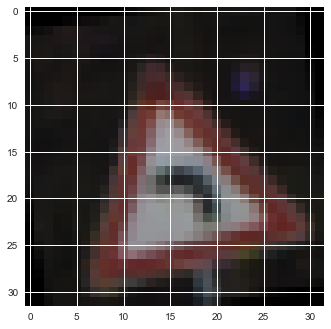

In [44]:
aa=50000
#plt.imshow(augmented_X_train[aa])
plt.imshow(aaa[aa])
print(labels.loc[bbb[aa]][1])

In [ ]:
#plt.imshow(aaa[60000])
aa = np.empty([300, 32, 32, 3], dtype=np.uint8)
bb = np.vstack([aa, X_train[:5]])
#print(np.shape(bb))
plt.imshow(bb[302])

In [ ]:
from PIL import Image

aaa = np.empty([300, 32, 32, 3], dtype=np.uint8)
aaa[0] = Image.fromarray(X_train[0], 'RGB')
plt.imshow(aaa[0])

In [ ]:
ccc= pd.DataFrame(data=bbb, columns=['ClassId'])
ddd = ccc.groupby('ClassId').size()

In [ ]:
print(bbb[bbb == 6])

In [ ]:
def saveToPickle(data, file_name=None, folder_path=None):
    if not os.path.isdir(folder_path):
        #print("Create \"preprocessed-data\" folder")
        os.mkdir(folder_path)
    else:
        print("\"preprocessed-data\" folder already exist")

    file_name = folder_path + file_name
    if not os.path.exists(file_name):
        try:
            with open(file_name, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
                print("Create", file_name)
        except Exception as e:
            print('Error: unable to save data to', file_name, 'because', e)
            
def loadPickle(file_name=None, folder_path=None):
    file = folder_path + file_name
    #print('Load')
    if os.path.exists(file):
        try:
            with open(file, 'rb') as f:
                return pickle.load(f)
                print("Open", file)
        except Exception as e:
            print('Error: unable to open data to', file, 'because', e)

#### Augmentation

In [ ]:
augmented_X_train, augmented_y_train = makeBallanceBetweenClasses(grouped_train_index, X_train, y_train)
augmented_X_valid, augmented_y_valid = makeBallanceBetweenClasses(grouped_valid_index, X_valid, y_valid)
augmented_X_test, augmented_y_test = makeBallanceBetweenClasses(grouped_test_index, X_test, y_test)

In [ ]:
## Load
#augmented_X_train = loadPickle(file_name='augmented_X_train.p', folder_path='./preprocessed-data/')
augmented_y_train = loadPickle(file_name='augmented_y_train.p', folder_path='./preprocessed-data/')

#augmented_X_valid = loadPickle(file_name='augmented_X_valid.p', folder_path='./preprocessed-data/')
augmented_y_valid = loadPickle(file_name='augmented_y_valid.p', folder_path='./preprocessed-data/')

#augmented_X_test = loadPickle(file_name='augmented_X_test.p', folder_path='./preprocessed-data/')
augmented_y_test = loadPickle(file_name='augmented_y_test.p', folder_path='./preprocessed-data/')

#print('The shape of the loaded processed X train dataset:', augmented_X_train.shape)
print('The shape of the loaded processed y train dataset:', augmented_y_train.shape)

#print('The shape of the loaded processed X valid dataset:', augmented_X_valid.shape)
print('The shape of the loaded processed y valid dataset:', augmented_y_valid.shape)

#print('The shape of the loaded processed X test dataset:', augmented_X_test.shape)
print('The shape of the loaded processed y test dataset:', augmented_y_test.shape)

#### Sharpen and Brigthen

In [ ]:
#sharpenAndBright_Train = np.zeros(augmented_X_train.shape)
#sharpenAndBright_Valid = np.zeros(augmented_X_valid.shape)
#sharpenAndBright_Test = np.zeros(augmented_X_test.shape)

for idx in tqdm(range(augmented_X_train.shape[0])):
    augmented_X_train[idx] = sharpenImage(enhanceContrastOfImage(augmented_X_train[idx]))

for idx in tqdm(range(augmented_X_valid.shape[0])):
    augmented_X_valid[idx] = sharpenImage(enhanceContrastOfImage(augmented_X_valid[idx]))

for idx in tqdm(range(augmented_X_test.shape[0])):
    augmented_X_test[idx] = sharpenImage(enhanceContrastOfImage(augmented_X_test[idx]))

#### Transformation

In [ ]:
grouped_aug_train = pd.DataFrame(data = augmented_y_train, columns=['ClassId']).groupby('ClassId')
grouped_aug_valid = pd.DataFrame(data = augmented_y_valid, columns=['ClassId']).groupby('ClassId')
grouped_aug_test = pd.DataFrame(data = augmented_y_test, columns=['ClassId']).groupby('ClassId')

transAndRotate(grouped_train_index, grouped_aug_train, augmented_X_train)
transAndRotate(grouped_valid_index, grouped_aug_valid, augmented_X_valid)
transAndRotate(grouped_test_index, grouped_aug_test, augmented_X_test)

#### Normalisation

In [ ]:
## Load
augmented_X_train = loadPickle(file_name='normalisation_Train.p', folder_path='./preprocessed-data/')
augmented_X_valid = loadPickle(file_name='normalisation_Valid.p', folder_path='./preprocessed-data/')
augmented_X_test = loadPickle(file_name='normalisation_Test.p', folder_path='./preprocessed-data/')

print('The shape of the loaded processed X train dataset:', augmented_X_train.shape)
print('The shape of the loaded processed X valid dataset:', augmented_X_valid.shape)
print('The shape of the loaded processed X test dataset:', augmented_X_test.shape)

In [ ]:
## Check whether image has a correct label
check = 42711
plt.imshow(augmented_X_train[check])
print(labels[labels['ClassId']==augmented_y_train[check]])

In [ ]:
## Plot class ID from index 0 to 9
numOfRows = 5
numOfColumns = 2

ClassIdIndex = 0

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(10, 10))
sns.set_style(style='white')

for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(augmented_X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=10)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 10:
            break

plt.tight_layout()

In [ ]:
## Plot classes from index 10 to 19
numOfRows = 5
numOfColumns = 2
ClassIdIndex = 10

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(10, 10))
sns.set_style(style='white')

for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(augmented_X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=10)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 20:
            break

plt.tight_layout()

In [ ]:
## Plot classes from index 20 to 29
numOfRows = 5
numOfColumns = 2
ClassIdIndex = 20

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(10, 10))
sns.set_style(style='white')

for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(augmented_X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=10)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 30:
            break

plt.tight_layout()

In [ ]:
## Plot classes from index 30 to 39
numOfRows = 5
numOfColumns = 2
ClassIdIndex = 30

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(10, 10))
sns.set_style(style='white')

for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(augmented_X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=10)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 40:
            break

plt.tight_layout()

In [ ]:
## Plot classes from index 40 to 42
numOfRows = 2
numOfColumns = 2

fig, ax = plt.subplots(numOfRows, numOfColumns, figsize=(5, 5))
sns.set_style(style='white')
ClassIdIndex = 40
for row in range(numOfRows):
    for column in range(numOfColumns):
        ax[row][column].imshow(augmented_X_train[firstTrainDataForEachClass.iloc[ClassIdIndex].values[0]])
        ax[row][column].set_title(labels.loc[ClassIdIndex][1], fontsize=10)
        ClassIdIndex += 1
        
        if ClassIdIndex >= 43:
            break

plt.tight_layout()

### Batches

In [ ]:
import math
def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    if batch_size > 0:
        assert len(features) == len(labels)

        output_batches = []
        sample_size = len(features)

        for start_i in range(0, sample_size, batch_size):
            end_i = start_i + batch_size
            batch = [features[start_i:end_i], labels[start_i:end_i]]
            output_batches.append(batch)
    else:
        assert len(features) == len(labels)
        
        output_batches = []
        sample_size = len(features)
        
        for start in range(sample_size):
            batch = [features[start], labels[start]]
            output_batches.append(batch)
            
    return output_batches

### Model Architecture

In [ ]:
rate = 0.001
EPOCHS = 10
BATCH_SIZE = 128
DROPOUT = 0.5

In [ ]:
from tensorflow.contrib.layers import flatten

def LeNet(x, dropout):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, dropout)

    # SOLUTION: Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, dropout)

    # SOLUTION: Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x64. Output = 1600.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 1600. Output = 1200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # SOLUTION: Layer 4: Fully Connected. Input = 1200. Output = 840.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)

    # SOLUTION: Layer 5: Fully Connected. Input = 840. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

## Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [ ]:
## Training Pipeline
logits =  LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
## Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, batch_size, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    #batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
    for batch_x, batch_y in tqdm(batches(batch_size, X_data, y_data)):
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
## Train the Model

with tf.Session() as session:
    session.run(tf. global_variables_initializer())
    num_examples = len(augmented_X_train)
    
    print("Training...")
    #print()
    for i in range(EPOCHS):
        shuffle_X, shuffle_y = shuffle(augmented_X_train, augmented_y_train)
        for batch_x, batch_y in tqdm(batches(BATCH_SIZE, shuffle_X, shuffle_y)):
            session.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
        
        validation_accuracy = evaluate(augmented_X_valid, augmented_y_valid, BATCH_SIZE, session)
        print("EPOCH {0} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    saver.save(session, './weights')
    print("Model Saved")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
# Launch the graph
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, './weights')
    accuracy = evaluate(augmented_X_test, augmented_y_test, BATCH_SIZE, session)
    print(accuracy)

In [ ]:
randomIndex = np.random.choice(X_test.shape[0], size=5)
newTestImages = X_test[randomIndex]
newTestLabels = labels.ix[y_test[randomIndex]]['SignName'].values
#print(newLabels)
## show 5 new images
for idx, image in enumerate(newTestImages):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.title(newTestLabels[idx])

In [ ]:
#predict_logits =  LeNet(x, keep_prob)

with tf.Session() as session:
    session.run(tf. global_variables_initializer())
    #loader = tf.train.import_meta_graph('./weights.meta')
    #loader.restore(session, tf.train.latest_checkpoint('./'))
    saver.restore(session, './weights')
    #session = tf.get_default_session()
    output = session.run(logits, feed_dict={x: newTestImages, keep_prob: DROPOUT})
print(output.argmax(axis=1))

In [ ]:
predict_index = output.argmax(axis=1)
predictLabels = labels.ix[predict_index]['SignName'].values

for idx, image in enumerate(newTestImages):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.title('<Correct Label: {0}>, <Predict Label: {1}>'.format(newTestLabels[idx], predictLabels[idx]))

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
# Launch the graph

def testEvaluate(X_data, y_data, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    assert len(X_data) == len(y_data)
    
    for idx in range(len(y_data)):
        accuracy = sess.run(accuracy_operation, feed_dict={x: X_data, y: y_data, keep_prob: DROPOUT})
        total_accuracy += accuracy
    return total_accuracy / num_examples

with tf.Session() as session:
    session.run(tf. global_variables_initializer())
    saver.restore(session, './weights')
    
    accuracyOnTest = testEvaluate(newTestImages, predict_index, session)
    
print(accuracyOnTest)

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")